<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: kNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

import pathlib
import random

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz

data_root_orig = tf.keras.utils.get_file('new_pic',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/new_pic/Guillaume_Loranchet
/root/.keras/datasets/new_pic/.DS_Store


In [4]:
data_root_orig_1 = tf.keras.utils.get_file('new_pic(1)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(1).tar.gz',
                                         untar=True)
data_root_1 = pathlib.Path(data_root_orig_1)
for item in data_root_1.iterdir():
  print(item)

/root/.keras/datasets/new_pic(1)/.DS_Store
/root/.keras/datasets/new_pic(1)/Guillaume_Paya
/root/.keras/datasets/new_pic(1)/Miha_S


In [5]:
data_root_orig_2 = tf.keras.utils.get_file('new_pic(2)',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/new_pic(2).tar.gz',
                                         untar=True)
data_root_2 = pathlib.Path(data_root_orig_2)
for item in data_root_2.iterdir():
  print(item)

/root/.keras/datasets/new_pic(2)/.DS_Store
/root/.keras/datasets/new_pic(2)/Nicholas_S


##Inspect the dataset

In [0]:
all_image_paths_0 = list(data_root.glob('*/*'))
all_image_paths_1 = list(data_root_1.glob('*/*'))
all_image_paths_2 = list(data_root_2.glob('*/*'))

all_image_paths = all_image_paths_2 + all_image_paths_1 + all_image_paths_0

all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [7]:
all_image_paths[:5]

['/root/.keras/datasets/new_pic(1)/Guillaume_Paya/Guillaume_Paya_75_rot_clock_0.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_74_sharpened_2_8_rot_clock_3.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_85_sp_9_rot_clock_1.png',
 '/root/.keras/datasets/new_pic(1)/Guillaume_Paya/Guillaume_Paya_75_sharpened_2_3_rot_anty_3.png',
 '/root/.keras/datasets/new_pic(1)/Miha_S/Miha_S_22_sharpened_2_0.png']

###Show images

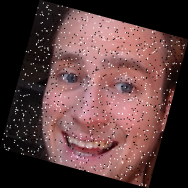

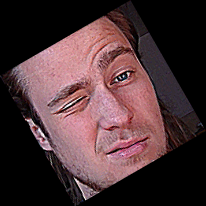

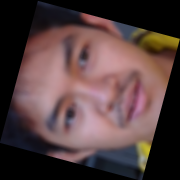

In [8]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [9]:
label_names_0 = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names_1 = sorted(item.name for item in data_root_1.glob('*/') if item.is_dir())
label_names_2 = sorted(item.name for item in data_root_2.glob('*/') if item.is_dir())

label_names = label_names_0 + label_names_1 + label_names_2
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [10]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [11]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 2, 2, 1, 2, 2, 0, 3, 2, 3]


###Load images with Tensor Flow

In [12]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/new_pic(1)/Guillaume_Paya/Guillaume_Paya_75_rot_clock_0.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

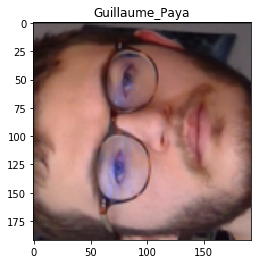

In [14]:
image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path)/255)
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [15]:
n = len(all_image_paths)

x_train_aux = [load_and_preprocess_image(all_image_paths[i]) for i in range(len(all_image_paths))]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n)])
x_train = x_train_aux_2[:int(0.75*n)] / 255   #normalize between 0 and 1
x_test = x_train_aux_2[int(0.75*n):] / 255
print(x_train.shape)
print(x_test.shape)

y_train_aux = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels])
y_train = y_train_aux[:int(0.75*n)]
y_test = y_train_aux[int(0.75*n):]
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(3510, 192, 192, 3)
(1170, 192, 192, 3)
(3510, 4)
(1170, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[0 1 0 0]


(3510, 4)


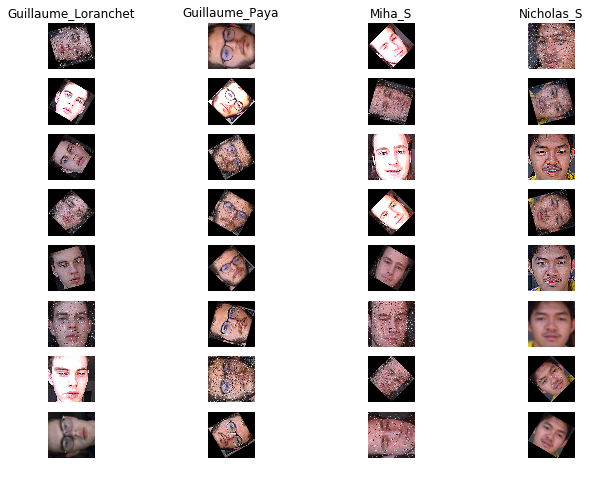

In [16]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    print(categories.shape)
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < len(categories):
            #print(j,i)
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels)

In [0]:
def train_model(model, x, y, x_test, y_test, batch_size=20, epochs=4, file_name=None):
    """
    Trains the model on the given data.
    """
    
    stop_early = keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0, patience=2, mode='auto')

    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, 
        validation_data=(x_test, y_test), shuffle=True)#, callbacks=[stop_early])
    
    if file_name:
        model.save(file_name)
    
    return ret

In [0]:
def dense_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='linear'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


#model = dense_model(x_train.shape[1:], len(labels))
#model.summary()
#ret = train_model(model, x_train, y_train, x_test, y_test)


##Convutional Net

In [21]:
def cnn_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create and train model
model = cnn_model(x_train.shape[1:], len(labels))
model.summary()

# Train the model
ret = train_model(model, x_train, y_train, x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 190, 190, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 190, 190, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
batch_normalization_v

##Testing

[1.1298457e-05 8.8063419e-02 8.1394297e-01 9.7982317e-02]
[8.4047252e-01 7.8699632e-05 1.5940852e-01 4.0395124e-05]
[8.9580065e-01 8.6654218e-05 1.0399933e-01 1.1336416e-04]
[3.1468824e-02 1.1607754e-05 9.6840996e-01 1.0967024e-04]
[3.2348311e-07 4.6466881e-05 9.9991763e-01 3.5483725e-05]
[1.3047176e-08 2.8133139e-04 9.9971336e-01 5.2372079e-06]
[3.0028653e-11 9.9999940e-01 3.4201764e-07 2.9869997e-07]
[1.5868439e-10 9.9999821e-01 1.7553366e-07 1.6590189e-06]
[2.5826090e-12 9.9999952e-01 1.2934618e-07 3.4182040e-07]
[2.1603544e-13 1.0000000e+00 4.6237205e-09 2.8787084e-09]


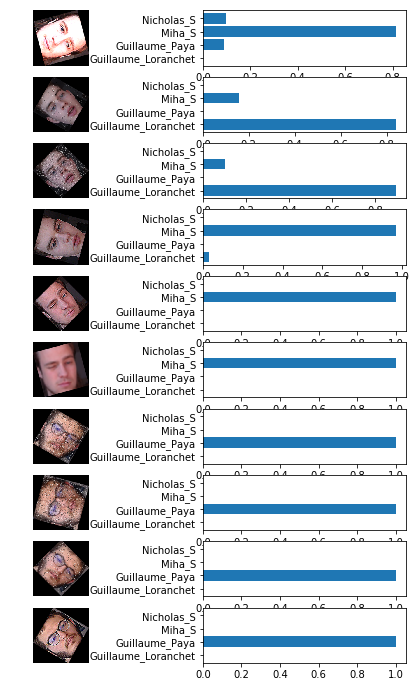

In [26]:
def predict(model, x, labels, file_name=None):
    y = model.predict(x)

    f, ax = plt.subplots(x.shape[0], 2, figsize=(8,12))
    y_pos = np.arange(len(labels))

    for i in range(x.shape[0]):
        ax[i,0].imshow(x[i,:,:,:])
        ax[i,0].axis('off')
        ax[i,1].barh(y_pos, y[i,:],align='center')
        ax[i,1].set_yticks(y_pos)
        ax[i,1].set_yticklabels(labels)
        print(y[i,:])
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
        
import random
i = random.randint(1,75)
predict(model, x_test[i:i+10,:,:,:], labels)
